In [23]:
import numpy as np
import pandas as pd
import os, pickle
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn import metrics
import sklearn.preprocessing as preprocessing
import statistics
import math

import sklearn.linear_model as lm
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV


from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings 
warnings.filterwarnings("ignore")




In [24]:
class DataPreparation:
    def __init__(self, outcome, features=None, categorical_features=None, one_hot_encoder=None):
        self._outcome = outcome
        self._features = features
        self._categorical_features = categorical_features
        self._one_hot_encoder = one_hot_encoder
 
    def getData(self, path, separator):
        data = pd.read_csv(path, sep = separator)
        if self._features:
            data = data[self._features]
        return data
    
    def replaceValues(self,colunas, data, tipo):
        if tipo == 'Binary':
            for coluna in colunas:
                coluna = data[coluna]
                for index in range (len(coluna)):
                    if coluna[index] >= 10:
                        coluna[index] = 1
                    else:
                        coluna[index] = 0
        elif tipo == 'FiveLevels':
            for coluna in colunas:
                coluna = data[coluna]
                for index in range (len(coluna)):
                    if coluna[index] <= 9:
                        coluna[index] = 5
                    elif coluna[index] >= 10 and coluna[index] <= 11 :
                        coluna[index] = 4
                    elif coluna[index] >= 12 and coluna[index] <= 13 :
                        coluna[index] = 3
                    elif coluna[index] >= 14 and coluna[index] <= 15 :
                        coluna[index] = 2
                    else:
                        coluna[index] = 1
        return data
    
    def getDataInfo(self,data):
        print("Number of Rows: {}\nNumber of Columns: {}".format(data.shape[0], data.shape[1]))
        print("The dataset has %d rows and %d columns " 
              % data.shape + "and has " + ("some" if data.isnull().values.any() else "no")  + " missing values.")
        return data.describe()
        
    def checkAndFillMissingValuesMode(self,data):
        features = data.columns
        for feature in features:
            if (data[feature].isnull().values.any() == True):
                print("-The column '{}', has'{}' missing values.\n"
                .format(feature, data[feature].isnull().sum()))
                data[feature].fillna(statistics.mode(data[feature]), inplace = True)
        return data
    
    def getFeaturesTypes(self,data):
        return(data.dtypes)
    
    def changeFeatureType(self,data,previousType, newType):
        for feature in data.columns:
            if ((data[feature].dtypes) == previousType):
                #for value in data[feature]:
                #value = value.astype(np.int64)
                data[feature] = data[feature].astype(np.int64)
        print(data.dtypes)
        return data

    def getBarPlots(self,data):
        plt.figure(figsize = (30, 30))
        for i in enumerate(data.columns):
            plt.subplot(int(data.columns.size/4)+1,4,i[0]+1)
            sns.countplot(i[1], data = data)
        
        
    def getCathegoricalFeatures(self,data):
        features = data.columns
        numeric_features = data._get_numeric_data().columns
        for column in data[numeric_features][:-2]:
            print("-The column '{}', has values that goes from '{}' to '{}' and is '{}' type.\n"
            .format(column, data[column].min(), data[column].max(), data[column].dtype))
            
        list_cathegorical_features = list(set(features) - set(numeric_features))
        for column in data[list_cathegorical_features][:-2]:
            print("-The column '{}' is a categorical column with values from '{}' to '{}' and is {} type"
          .format(column, data[column].min(), data[column].max(), data[column].dtype))
            
        return list_cathegorical_features
    
    def getFeaturesDescription(self,data, label):
        for col in data.columns:
            if col != label:
                data[col].describe()
    
    def CorrelationMatrix(self,data):
        plt.figure(figsize=(18,16))
        sns.heatmap(data.corr(),annot=True)
        plt.show()
        
    def Vif(self,data,label):
        thresh = 10
        independent_variables = []
        print(independent_variables)
        for col in data.columns:
            if col != label:
                independent_variables.append(col)
        for i in np.arange(0, len(data)):
            vif = [variance_inflation_factor(data[independent_variables].values,ix)
                for ix in range(data[independent_variables].shape[1])]
            maxloc = vif.index(max(vif))
            if max(vif) > thresh:
                print('vif :', vif)
                print('dropping', data[independent_variables].columns[maxloc],
                      'at index', maxloc)
                del independent_variables[maxloc]
            else:
                break

        print('Final variables :',independent_variables)
        return independent_variables
    
    def oneHotEncoding(self, data):
        if self._categorical_features:
            categorial = data[self._categorical_features]
        else:
            categorical = data.select_dtypes(exclude=np.number)
            categorical_features = categorical.columns
        if self._one_hot_encoder:
            one_hot_encoder = self._one_hot_encoder
        else:
            one_hot_encoder = preprocessing.OneHotEncoder(
                sparse=False,
                drop='first')
        categorical = one_hot_encoder.fit_transform(categorical)
        categorical_columns = one_hot_encoder.get_feature_names_out(categorical_features)
        categorical = pd.DataFrame(categorical, columns=categorical_columns)
        continuous = data.select_dtypes(include=np.number)
        data = pd.concat([categorical, continuous], axis=1)
        return data, one_hot_encoder
    
    def normalizeData(self,data,label):
        numeric_features = data.loc[:, data.columns != label].select_dtypes(include=np.number).columns.tolist()
        numeric_features = ['age','Medu','Fedu','traveltime','studytime','failures','absences','famrel','freetime',
                            'goout','Dalc','Walc','health','G1','G2']
        
        sc = preprocessing.StandardScaler()
        sc.fit(data[numeric_features])
        data[numeric_features] = sc.transform(data[numeric_features])
        return data
    
    def splitData(self, data, independent_variables, size_test):
        x, y = data[independent_variables], data.iloc[:, [-1]]
        X_train , X_test , y_train , y_test = train_test_split(x, y, test_size = size_test, random_state = 2017)
        return X_train, X_test, y_train, y_test
    
    def fit(self, X_train, y_train, algorithm):
        model = algorithm.fit(X_train, y_train)
        return model
    
    def predict(self, model, X_test):
        result = model.predict(X_test)
        return result
    
    def modelMetrics(self,model, X_test, y_test, y_test_pred):
        print('Train MAE : ',metrics.mean_absolute_error(y_test,y_test_pred))
        print('Train RMSE',np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
        #print('R- Squared = ',metrics.r2_score (y_test, y_test_pred))
        #print("The MAE of the Model is:", metrics.mean_absolute_error(y_test, y_test_pred))
        #print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))
        #print ('Test confusion matrix \n', metrics.confusion_matrix (y_test, y_test_pred))
        #print ('Classification report : \n',metrics.classification_report(y_test,y_test_pred))

In [25]:
class SupervisedMlModels:
    def __init__(self, x_train=None, x_test=None, y_train=None, y_test=None):
        self._x_train = x_train
        self._x_test = x_test
        self._y_train = y_train
        self._y_test = y_test
        
    def hyperparameterTuning(self, model):
        if model == 'LinearRegression':
            grid = lm.LinearRegression()
        elif model == 'Svm':
            param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
            grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
        elif model == 'RandomForest':
            param_grid = {
                'bootstrap': [True],
                'max_depth': [80, 90, 100, 110],
                'max_features': [2, 3],
                'min_samples_leaf': [3, 4, 5],
                'min_samples_split': [8, 10, 12],
                'n_estimators': [100, 200, 300, 1000]
            }
            grid = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, 
                                      cv = 3, n_jobs = -1, verbose = 2)
        elif model == 'DecisionTree':
            params = {
                'max_depth': [2, 3, 5, 10, 20],
                'min_samples_leaf': [5, 10, 20, 50, 100],
                'criterion': ["gini", "entropy"]
            }
            grid = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), 
                                       param_grid=params, 
                                       cv=10, n_jobs=-1, verbose=1, scoring = "accuracy")
        elif model == 'NearestNeighbour':
            k_range = list(range(1, 31))
            param_grid = dict(n_neighbors=k_range)

            grid = GridSearchCV(KNeighborsClassifier(), param_grid, 
                                cv=10, scoring='accuracy', return_train_score=False,verbose=1)
        elif model == 'NaiveBayes':
            grid = MultinomialNB();
        else:
            grid = 0
        return grid
            
        
 
    def fit(self, x_train, y_train, algorithm):
        model = algorithm.fit(x_train, y_train)
        return model
    
    def predict(self, model, x_test):
        result = np.round(model.predict(x_test))
        return result
    
    def modelMetrics(self,model, X_test, y_test, y_test_pred):
        print('Train MAE : ',metrics.mean_absolute_error(y_test,y_test_pred))
        print('Train RMSE',np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
        #print('R- Squared = ',metrics.r2_score (y_test, y_test_pred))
        #print("The MAE of the Model is:", metrics.mean_absolute_error(y_test, y_test_pred))
        #print("Accuracy: ", metrics.accuracy_score(y_test, y_test_pred))

In [63]:
if __name__ == '__main__':
    path1 = 'Datasets\student-mat.csv'
    path2 = 'Datasets\student-por.csv'
    model_instance = DataPreparation(outcome = 'yes', features=None, categorical_features=None, one_hot_encoder=None)
    data_math = model_instance.getData(path1, separator = ';')
    print(data_math)
    data_por = model_instance.getData(path2, separator = ';')
    data_info_mat = model_instance.getDataInfo(data_math) 
    data_info_por = model_instance.getDataInfo(data_por)
    data_math = model_instance.checkAndFillMissingValuesMode(data_math)
    data_por = model_instance.checkAndFillMissingValuesMode(data_por)
    features_types_mat = model_instance.getFeaturesTypes(data_math)
    data_math = model_instance.changeFeatureType(data_math, 'float64', 'int64')
    dat_por = model_instance.changeFeatureType(data_por, 'float64', 'int64')
    
    #data_math = model_instance.replaceValues(['G1','G2','G3'], data_math, tipo = 'FiveLevels')
    #dat_por = model_instance.replaceValues(['G1','G2','G3'], dat_por, tipo = 'FiveLevels')
    
    data_math, one_hot_math = model_instance.oneHotEncoding(data_math)
    #independent_variables_math = model_instance.Vif(data_math,'G3')

    data_math = model_instance.normalizeData(data_math,'G3')
    data_math = data_math[data_math['G3']<=20]
    X_train_math, X_test_math, y_train_math, y_test_math = model_instance.splitData(data_math, 
                                                                     data_math.columns[data_math.columns != 'G3'],
                                                                     #independent_variables_math, 
                                                                     size_test = 0.3)
    
    data_por, one_hot_por = model_instance.oneHotEncoding(data_por)
    #independent_variables_por = model_instance.Vif(data_por,'G3')
    
    data_por = model_instance.normalizeData(data_por,'G3')
    data_por = data_por[data_por['G3']<=20]
    X_train_por, X_test_por, y_train_por, y_test_por = model_instance.splitData(data_por, 
                                                                     data_por.columns[data_por.columns != 'G3'],
                                                                     #independent_variables_por, 
                                                                     size_test = 0.3)
    
    print(X_train_por)

    school sex  age address famsize Pstatus  Medu  Fedu      Mjob      Fjob  \
0       GP   F   18       U     GT3       A     4     4   at_home   teacher   
1       GP   F   17       U     GT3       T     1     1   at_home     other   
2       GP   F   15       U     LE3       T     1     1   at_home     other   
3       GP   F   15       U     GT3       T     4     2    health  services   
4       GP   F   16       U     GT3       T     3     3     other     other   
..     ...  ..  ...     ...     ...     ...   ...   ...       ...       ...   
390     MS   M   20       U     LE3       A     2     2  services  services   
391     MS   M   17       U     LE3       T     3     1  services  services   
392     MS   M   21       R     GT3       T     1     1     other     other   
393     MS   M   18       R     LE3       T     3     2  services     other   
394     MS   M   19       U     LE3       T     1     1     other   at_home   

     ... famrel freetime  goout  Dalc  Walc health 

In [64]:
print(data_math[data_math['G3']>20])

Empty DataFrame
Columns: [school_MS, sex_M, address_U, famsize_LE3, Pstatus_T, Mjob_health, Mjob_other, Mjob_services, Mjob_teacher, Fjob_health, Fjob_other, Fjob_services, Fjob_teacher, reason_home, reason_other, reason_reputation, guardian_mother, guardian_other, schoolsup_yes, famsup_yes, paid_yes, activities_yes, nursery_yes, higher_yes, internet_yes, romantic_yes, age, Medu, Fedu, traveltime, studytime, failures, famrel, freetime, goout, Dalc, Walc, health, absences, G1, G2, G3]
Index: []

[0 rows x 42 columns]


In [65]:
if __name__ == '__main__':
    model_ml_math = SupervisedMlModels(x_train=None, x_test=None, y_train=None, y_test = None)
    #algorithms_math = ['LinearRegression','DecisionTree','Svm','RandomForest','NearestNeighbour','NaiveBayes']
    algorithms_math = ['DecisionTree']
    for algorithm in algorithms_math:
        model_math = model_ml_math.hyperparameterTuning(algorithm)
        if model_math != 0:
            print('O algoritmo escolhido foi',algorithm)
            model_ml_math.fit(X_train_math, y_train_math, model_math)
            y_test_pred_math = model_ml_math.predict(model_math,X_test_math)
            model_ml_math.modelMetrics(model_math,X_test_math,y_test_math, y_test_pred_math)
            pickle.dump(model_math,open("Models/Maths/Grade/"+algorithm+'.pkl','wb'))
        else:
            print("O seguinte modelo não existe")

O algoritmo escolhido foi DecisionTree
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Train MAE :  1.1864406779661016
Train RMSE 2.2848061149801855


In [66]:
if __name__ == '__main__':
    model_ml_por = SupervisedMlModels(x_train=None, x_test=None, y_train=None, y_test = None)
    algorithms_por = ['LinearRegression','DecisionTree','Svm','RandomForest','NearestNeighbour','NaiveBayes']
    algorithms_por = ['DecisionTree']
    for algorithm in algorithms_por:
        model_por = model_ml_por.hyperparameterTuning(algorithm)
        if model_por != 0:
            print('O algoriportmo escolhido foi',algorithm)
            model_ml_por.fit(X_train_por, y_train_por, model_por)
            y_test_pred_por = model_ml_por.predict(model_por,X_test_por)
            model_ml_por.modelMetrics(model_por,X_test_por,y_test_por, y_test_pred_por)
            pickle.dump(model_por,open("Models/Portuguese/Grade/"+algorithm+'.pkl','wb'))
        else:
            print("O seguinte modelo não existe")

O algoriportmo escolhido foi DecisionTree
Fitting 10 folds for each of 50 candidates, totalling 500 fits
Train MAE :  0.8974358974358975
Train RMSE 1.8158843293106246


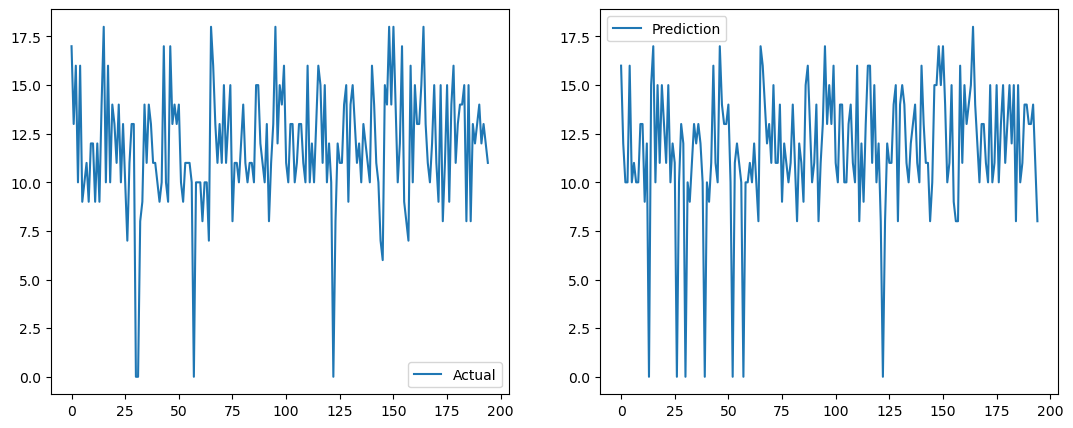

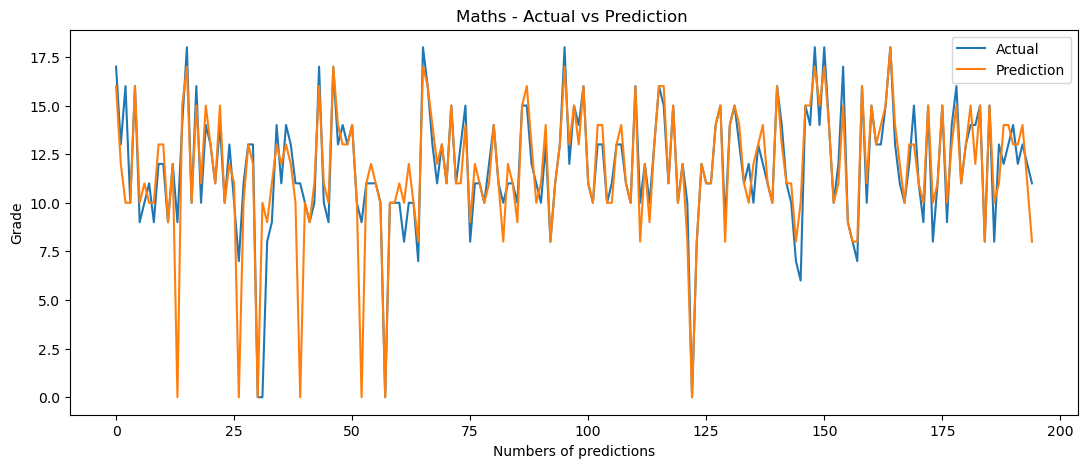

In [80]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test_por)), y_test_por, label='Actual')
ax2.plot(np.arange(len(y_test_pred_por)), y_test_pred_por, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test_por)), y_test_por, label='Actual')
ax3.plot(np.arange(len(y_test_pred_por)), y_test_pred_por, label='Prediction')

ax3.set_title("Maths - Actual vs Prediction ")
ax3.set_xlabel("Numbers of predictions")
ax3.set_ylabel("Grade")
ax3.legend()

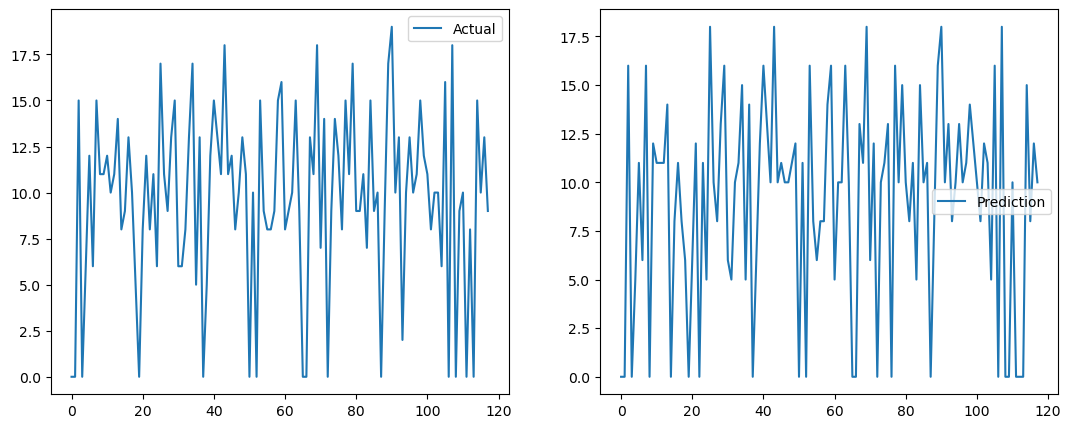

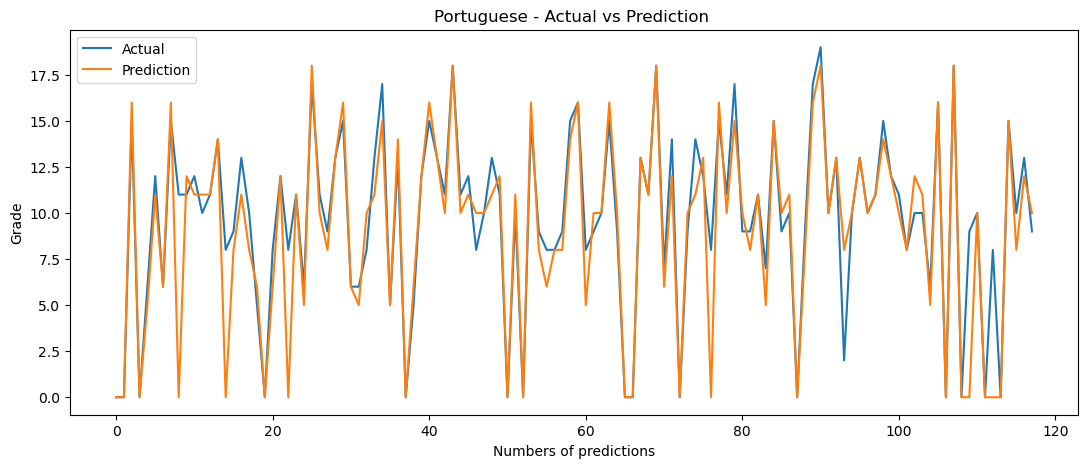

In [81]:
f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

ax1.plot(np.arange(len(y_test_math)), y_test_math, label='Actual')
ax2.plot(np.arange(len(y_test_pred_math)), y_test_pred_math, label='Prediction')

ax1.legend()
ax2.legend()

f, ax3 = plt.subplots(nrows=1, ncols=1, figsize=(13, 5))

ax3.plot(np.arange(len(y_test_math)), y_test_math, label='Actual')
ax3.plot(np.arange(len(y_test_pred_math)), y_test_pred_math, label='Prediction')

ax3.set_title("Portuguese - Actual vs Prediction ")
ax3.set_xlabel("Numbers of predictions")
ax3.set_ylabel("Grade")
ax3.legend()